# PipelineRun visualize and profile
In this tutorial, you will learn how to visualize and profile a PipelineRun.

In [ ]:
# Install azureml-sdk with PipelineRun
# Important! After install succeed, need to restart kernel

%config IPCompleter.greedy=True
!pip install azureml-pipeline-wrapper[notebooks]==0.1.0.20312968 --extra-index-url https://azuremlsdktestpypi.azureedge.net/CLI-SDK-Runners-Validation/20312968 --user --upgrade

In [ ]:
from azureml.core import Workspace, Experiment
from azureml.pipeline.wrapper import PipelineRun, Pipeline, Module, dsl

In [ ]:
# configure your workspace info here
subscription_id="4faaaf21-663f-4391-96fd-47197c630979"
resource_group="DesignerTestRG"
name="DesignerTest-centraluseuap"

ws = Workspace.get(subscription_id=subscription_id, resource_group=resource_group, name=name)
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

In [ ]:
# get modules
split_data_func, select_columns_in_dataset_func, score_model_func, evaluate_model_func, boosted_decision_tree_regression_func, train_model_func, clean_missing_data_func, decision_forest_regression_func = Module.batch_load(ws, identifiers=[('Split Data', 'azureml'), ('Select Columns in Dataset', 'azureml'), ('Score Model', 'azureml'), ('Evaluate Model', 'azureml'), ('Boosted Decision Tree Regression', 'azureml'), ('Train Model', 'azureml'), ('Clean Missing Data', 'azureml'), ('Decision Forest Regression', 'azureml')])

In [ ]:
# get dataset
from azureml.core import Dataset
from azureml.pipeline.wrapper._dataset import get_global_dataset_by_path
automobile_price_data_raw = get_global_dataset_by_path(ws, 'automobile_price_data_raw', 'GenericCSV/Automobile_price_data_(Raw)')

In [ ]:
# define pipeline
@dsl.pipeline(name='sample pipeline', description='sample pipeline to visualize', default_compute_target='aml-compute')
def generated_pipeline():
    select_columns_in_dataset_0 = select_columns_in_dataset_func(
        dataset=automobile_price_data_raw,
        select_columns='["AllColumns",{"ColumnNames":["normalized-losses"],"Exclude":true}]')
    
    clean_missing_data_0 = clean_missing_data_func(
        dataset=select_columns_in_dataset_0.outputs.results_dataset,
        columns_to_be_cleaned='["AllColumns"]',
        minimum_missing_value_ratio=0.0,
        maximum_missing_value_ratio=1.0,
        cleaning_mode='Remove entire row')
    
    split_data_0 = split_data_func(
        dataset=clean_missing_data_0.outputs.cleaned_dataset,
        splitting_mode='Split Rows',
        fraction_of_rows_in_the_first_output_dataset=0.7,
        randomized_split=True,
        random_seed=0,
        stratified_split='False',
        stratification_key_column='')
    
    decision_forest_regression_0 = decision_forest_regression_func(
        create_trainer_mode='SingleParameter',
        number_of_decision_trees=8,
        maximum_depth_of_the_decision_trees=32,
        minimum_number_of_samples_per_leaf_node=1,
        resampling_method='Bagging Resampling')
    
    boosted_decision_tree_regression_0 = boosted_decision_tree_regression_func(
        create_trainer_mode='SingleParameter',
        maximum_number_of_leaves_per_tree=20,
        minimum_number_of_training_instances_required_to_form_a_leaf=10,
        the_learning_rate=0.2,
        total_number_of_trees_constructed=100,
        random_number_seed=None)
    
    train_model_0 = train_model_func(
        untrained_model=boosted_decision_tree_regression_0.outputs.untrained_model,
        dataset=split_data_0.outputs.results_dataset1,
        label_column='[{"KeepInputDataOrder":true,"ColumnNames":["price"]}]')
    
    train_model_1 = train_model_func(
        dataset=split_data_0.outputs.results_dataset1,
        untrained_model=decision_forest_regression_0.outputs.untrained_model,
        label_column='[{"KeepInputDataOrder":true,"ColumnNames":["price"]}]')
    
    score_model_0 = score_model_func(
        trained_model=train_model_0.outputs.trained_model,
        dataset=split_data_0.outputs.results_dataset2,
        append_score_columns_to_output=True)
    
    score_model_1 = score_model_func(
        trained_model=train_model_1.outputs.trained_model,
        dataset=split_data_0.outputs.results_dataset2,
        append_score_columns_to_output=True)
    
    evaluate_model_0 = evaluate_model_func(
        scored_dataset=score_model_0.outputs.scored_dataset,
        scored_dataset_to_compare=score_model_1.outputs.scored_dataset)

In [ ]:
# create a pipeline
pipeline = generated_pipeline()

# submit a pipeline run
submited_pipeline_run = pipeline.submit(experiment_name='test-profiling')

**Visualize the pipeline run by calling** ```submited_pipeline_run.wait_for_completion()```

After a short period of loading time, the graph of submited_pipeline_run will show up with current run status.
And the running status will be refreshed automatically.


![visualize.png](.\assets\images\visualize.png)

At the same time, we will gather the profiling data for the pipeline run in the backend.
When the profiling data is ready, you can click the 'open profiling' button in the tool bar to open the pipeline run profile Gantt view.

![gantt.png](.\assets\images\gantt.png)
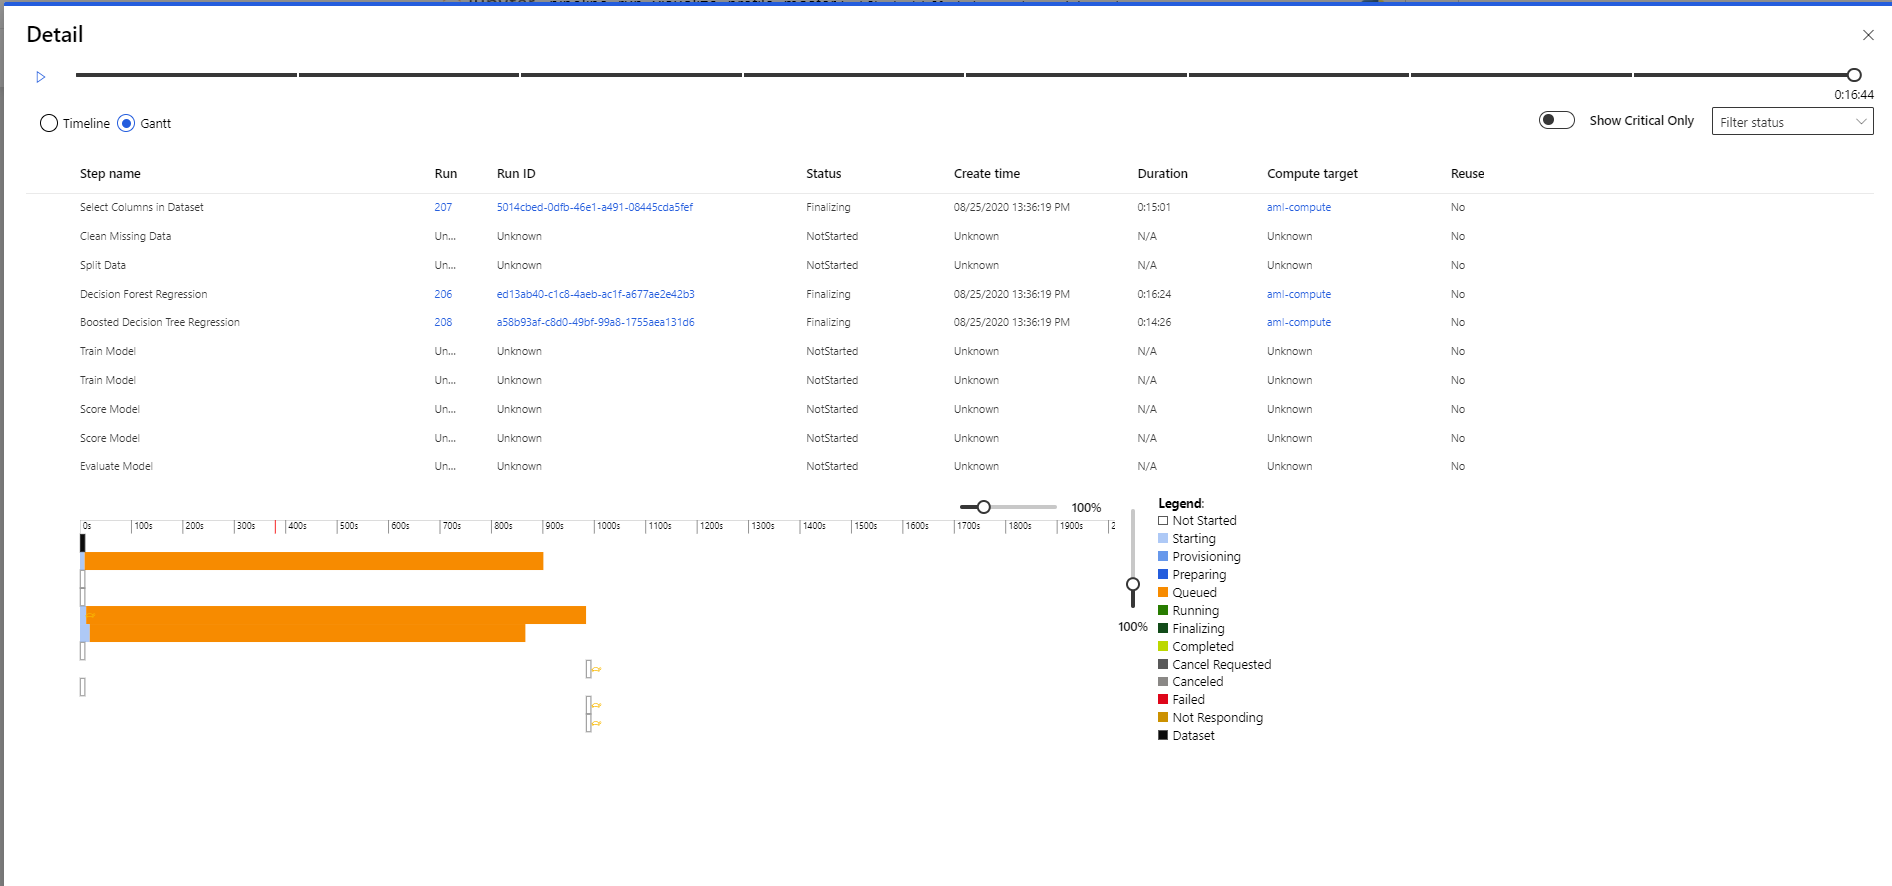
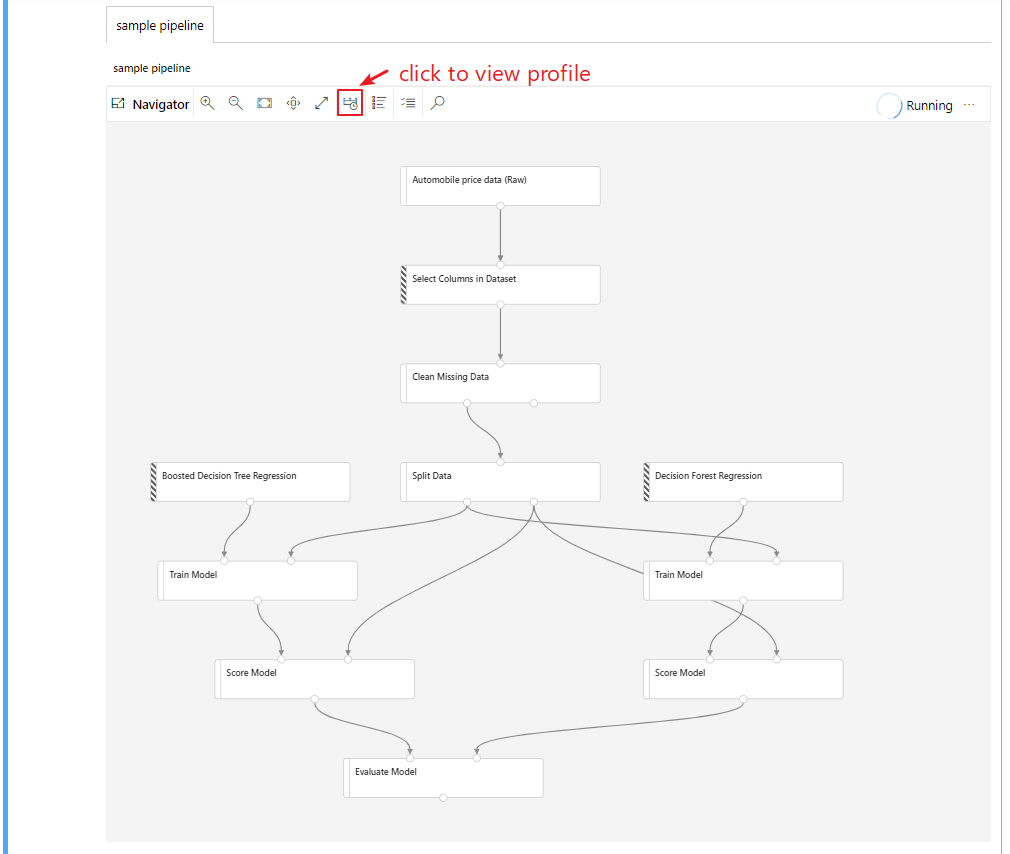

In [ ]:
# visualize the pipeline run in wait_for_completion()
submited_pipeline_run.wait_for_completion()

**You can also visualize and profile an existing Pipeline from your workspace**

Assume you have a PipelineRun which id is 'a6f5f21c-1ab0-48ee-aa4a-16c6f0662334' in Experiment 'test-profiling' of your workspace.

In [ ]:
# get your experiment
experiment = Experiment(ws, 'test-profiling')

# get an existing pipeline run in your experiment
existing_run = PipelineRun(experiment, 'a6f5f21c-1ab0-48ee-aa4a-16c6f0662334')

**Visualize the pipeline run by calling** ```submited_pipeline_run.visualize()```

*The behavior of method visualize() is the same as method wait_for_completion. You could also call wait_for_completion instead of visualize() here.*

For a completed run, you can also view each node's driver logs inside widget by click the 'View Logs' in right-click context memu for each node.

![view-logs.png](.\assets\images\view-logs.png)
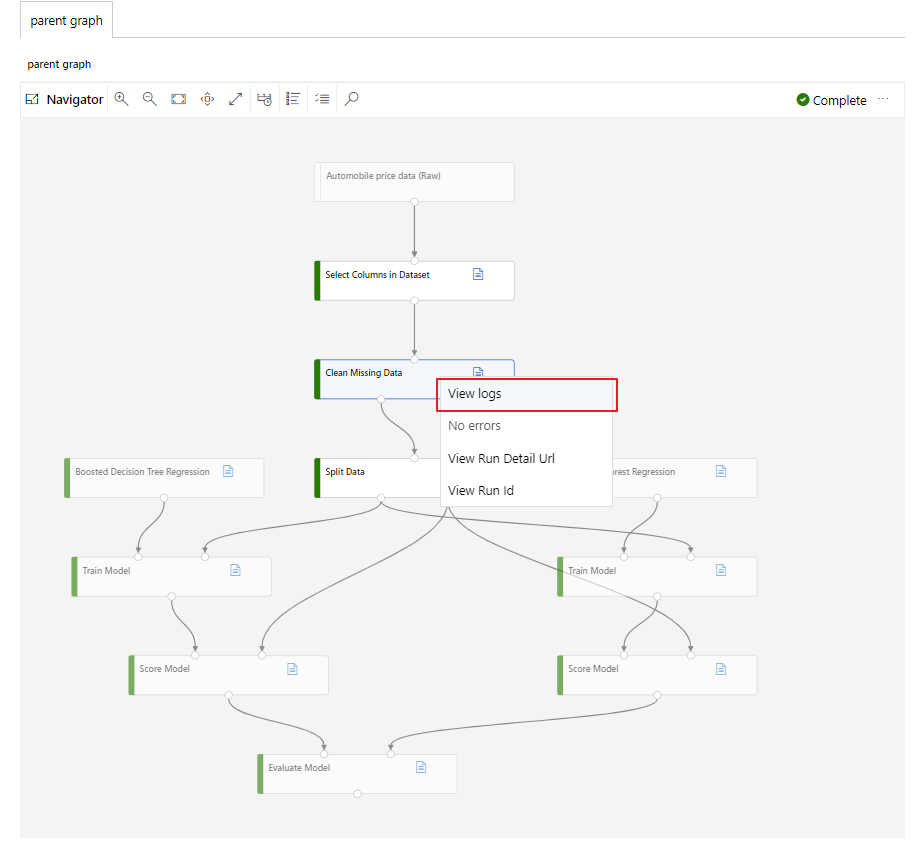

In [ ]:
existing_run.visualize()

**View profile Gantt view directly**

Instead of open the Gantt View by click the 'open profiling' button in the widget. You can also view it directly by calling the profile() method of a PipelineRun.

![gantt-directly.png](.\assets\images\gantt-directly.png)
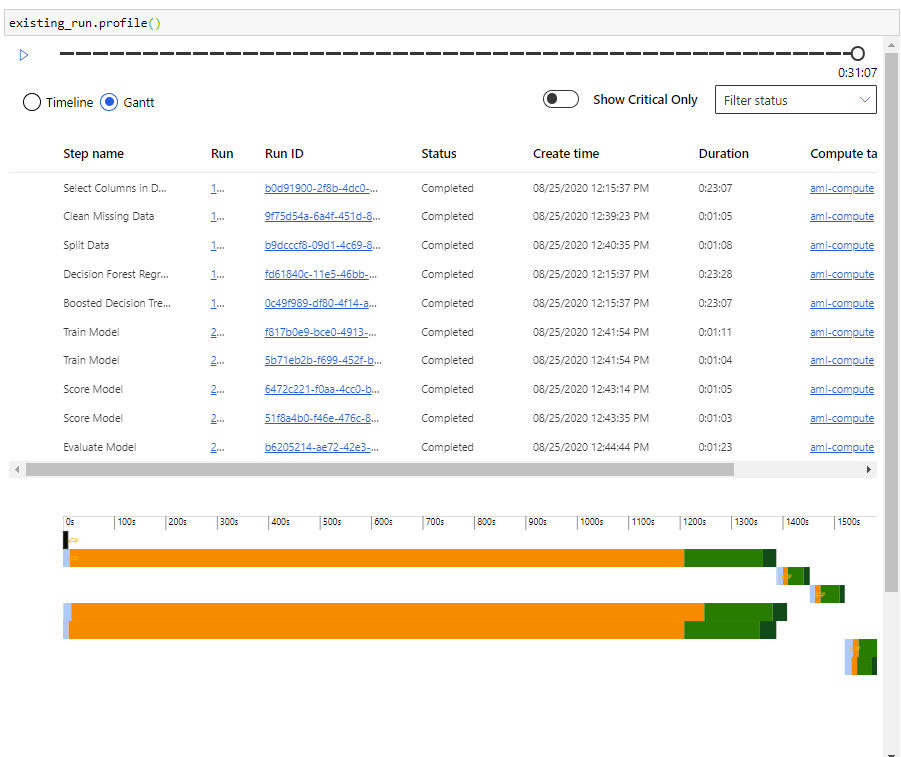

In [ ]:
existing_run.profile()